In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finance_byu.summarize import summary
import statsmodels.formula.api as smf
import yfinance as yf

### Data Loading

In [21]:
df = pd.read_parquet("~/Data/BOQ_data.parquet")

df.tail()

,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,s2invt,s2rect,sale,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv
3568650,0.211263,0.114912,-0.746238,0.861151,-12.189408,2023-08-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000152,0.708916,2.250092e+07,-1.580970
3568651,0.211263,0.114912,-0.750723,0.865635,-11.613183,2023-09-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000133,0.465122,1.476294e+07,-0.371920
3568652,0.211263,0.114912,-0.731231,0.846143,-12.752123,2023-10-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000177,0.531342,1.686876e+07,0.809301
3568653,0.211263,0.114912,-0.731231,0.846143,-7.943286,2023-11-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000245,0.614813,1.954419e+07,0.278301
3568654,0.211263,0.114912,-0.731231,0.846143,-9.359996,2023-12-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000186,0.599491,1.905735e+07,0.967711


In [22]:
# Create initial dataframe. Keep only necessary columns, and generate date variables

keep = ['DATE', 'PERMNO', 'BEME', 'E2P', 'sale', 'ME', 'PRC', 'RET', ]

df = df[keep]

df = df.rename(columns={'DATE':'caldt','PERMNO':'permno','BEME':'beme', 'E2P': 'ep', 'sale': 'sales', 'ME': 'me', 'PRC':'prc', 'RET': 'ret'})

df = df.sort_values(['permno','caldt'])

df['mdt'] = df['caldt'].dt.strftime("%Y-%m")
df['month'] = df['caldt'].dt.strftime("%m")
df['year'] = df['caldt'].dt.strftime("%Y")

# In sample period
start = '1963-04-01'
end = '1990-04-30'
# Out of sample period
# start = '1990-04-30'
# end = '2024-10-07'
df = df[df['caldt'] >= start]
df = df[df['caldt'] <= end]

df = df.reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year
1382626,1985-08-31,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-08,08,1985
1382627,1985-09-30,93324.0,NaN,NaN,NaN,1149.609375,0.078125,-0.166667,1985-09,09,1985
1382628,1985-10-31,93324.0,NaN,NaN,NaN,1609.453125,0.109375,0.400000,1985-10,10,1985
1382629,1985-11-30,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-11,11,1985
1382630,1985-12-31,93324.0,NaN,NaN,NaN,NaN,0.093750,-0.142857,1985-12,12,1985


Feature Generation

In [23]:
# Generate features from the last 12 months

formation_period = 12 # months

# 1 month sales growth
df['sg'] = df.groupby("permno")['sales'].pct_change(fill_method=None)

# Log 1 months sales growth
df['log_sg'] = np.log(1+df['sg'])

# Past 1 year log sales growth
df[f'log_sg_{formation_period}'] = df.groupby('permno').rolling(formation_period,formation_period)['log_sg'].sum().reset_index(drop=True)

df.tail()

/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12
1382626,1985-08-31,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-08,08,1985,NaN,NaN,NaN
1382627,1985-09-30,93324.0,NaN,NaN,NaN,1149.609375,0.078125,-0.166667,1985-09,09,1985,NaN,NaN,NaN
1382628,1985-10-31,93324.0,NaN,NaN,NaN,1609.453125,0.109375,0.400000,1985-10,10,1985,NaN,NaN,NaN
1382629,1985-11-30,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-11,11,1985,NaN,NaN,NaN
1382630,1985-12-31,93324.0,NaN,NaN,NaN,NaN,0.093750,-0.142857,1985-12,12,1985,NaN,NaN,NaN


In [24]:
# Generate target variable

# Log 1 month return
df['log_ret'] = np.log(1 + df['ret'])

holding_period = 1 # months

# 12 month holding period return
df[f'ret_{holding_period}'] = df.groupby('permno').rolling(holding_period,holding_period)['log_ret'].sum().reset_index(drop=True)
df[f'ret_{holding_period}'] = df.groupby('permno')[f'ret_{holding_period}'].shift(-(holding_period-1))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12,log_ret,ret_1
1382626,1985-08-31,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-08,08,1985,NaN,NaN,NaN,-0.154151,-0.154151
1382627,1985-09-30,93324.0,NaN,NaN,NaN,1149.609375,0.078125,-0.166667,1985-09,09,1985,NaN,NaN,NaN,-0.182322,-0.182322
1382628,1985-10-31,93324.0,NaN,NaN,NaN,1609.453125,0.109375,0.400000,1985-10,10,1985,NaN,NaN,NaN,0.336472,0.336472
1382629,1985-11-30,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-11,11,1985,NaN,NaN,NaN,-0.154151,-0.154151
1382630,1985-12-31,93324.0,NaN,NaN,NaN,NaN,0.093750,-0.142857,1985-12,12,1985,NaN,NaN,NaN,-0.154151,-0.154151


In [25]:
# Lag all formation variables by 1 month
df['beme_lag'] = df.groupby('permno')['beme'].shift(1)
df['sg_lag'] = df.groupby('permno')[f'log_sg_{formation_period}'].shift(1)
df['prc_lag'] = df.groupby('permno')['prc'].shift(1)

# Remove stocks that don't have formation variables and low priced stocks
df = df.query("beme_lag == beme_lag and sg_lag == sg_lag and prc_lag >= 5").reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12,log_ret,ret_1,beme_lag,sg_lag,prc_lag
696764,1989-02-28,93236.0,0.072630,-0.176983,0.300,8772.5000,5.5000,-0.011236,1989-02,02,1989,0.0,0.0,1.791759,-0.011300,-0.011300,0.072630,1.791759,5.5625
696765,1989-03-31,93236.0,0.072630,-0.176983,0.300,7177.5000,4.5000,-0.181818,1989-03,03,1989,0.0,0.0,1.791759,-0.200671,-0.200671,0.072630,1.791759,5.5000
696766,1987-09-30,93287.0,1.147422,-0.451362,42.952,47043.5625,6.1875,0.053191,1987-09,09,1987,0.0,0.0,-0.435674,0.051825,0.051825,1.147422,-0.435674,5.8750
696767,1987-10-31,93287.0,1.147422,-0.451362,42.952,22809.0000,3.0000,-0.515152,1987-10,10,1987,0.0,0.0,-0.435674,-0.723919,-0.723919,1.147422,-0.435674,6.1875
696768,1987-08-31,93316.0,1.244688,0.036332,90.400,11961.0000,4.5000,-0.100000,1987-08,08,1987,0.0,0.0,0.142063,-0.105361,-0.105361,1.244688,0.142063,5.0000


### Portfolio Formation

In [26]:
# Create quantiles based off of b/m lag and sales growth lag using independent sorts
df['beme_bins'] = df.groupby("mdt")['beme_lag'].transform(lambda x: pd.qcut(x, 3, labels=False))
df['sg_bins'] = df.groupby("mdt")['sg_lag'].transform(lambda x: pd.qcut(x, 3, labels=False))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,...,sg,log_sg,log_sg_12,log_ret,ret_1,beme_lag,sg_lag,prc_lag,beme_bins,sg_bins
696764,1989-02-28,93236.0,0.072630,-0.176983,0.300,8772.5000,5.5000,-0.011236,1989-02,02,...,0.0,0.0,1.791759,-0.011300,-0.011300,0.072630,1.791759,5.5625,0,2
696765,1989-03-31,93236.0,0.072630,-0.176983,0.300,7177.5000,4.5000,-0.181818,1989-03,03,...,0.0,0.0,1.791759,-0.200671,-0.200671,0.072630,1.791759,5.5000,0,2
696766,1987-09-30,93287.0,1.147422,-0.451362,42.952,47043.5625,6.1875,0.053191,1987-09,09,...,0.0,0.0,-0.435674,0.051825,0.051825,1.147422,-0.435674,5.8750,2,0
696767,1987-10-31,93287.0,1.147422,-0.451362,42.952,22809.0000,3.0000,-0.515152,1987-10,10,...,0.0,0.0,-0.435674,-0.723919,-0.723919,1.147422,-0.435674,6.1875,2,0
696768,1987-08-31,93316.0,1.244688,0.036332,90.400,11961.0000,4.5000,-0.100000,1987-08,08,...,0.0,0.0,0.142063,-0.105361,-0.105361,1.244688,0.142063,5.0000,2,1


In [27]:
# Group stocks by year and bins
port = df.groupby(['mdt', 'beme_bins', 'sg_bins'])[f'ret_{holding_period}'].mean().unstack(level=['beme_bins', 'sg_bins'])

# Drop rows with no holding period returns
port = port.dropna()

# Value portfolio is high b/m and low sg
# Glamor portfolio is low b/m and high sg
# Create a spread portfolio with long value and short glamor stocks
port['spread'] = port[2][0] - port[0][2]

port_100 = port * 100

port_100.tail()

beme_bins         0                              1                      \
sg_bins           0         1          2         0         1         2   
mdt                                                                      
1989-12    0.228956  1.053763   0.436706 -0.440077  0.465636 -0.172778   
1990-01   -8.184343 -8.666219 -11.657169 -6.827502 -8.422072 -8.487475   
1990-02    0.824277  0.935653   2.496803  0.595017  2.250109  2.812867   
1990-03    2.353086  3.225238   4.179669  2.572299  2.528072  3.931176   
1990-04   -3.336472 -1.976714  -3.759968 -3.573459 -3.562976 -4.327056   

beme_bins         2                        spread  
sg_bins           0         1         2            
mdt                                                
1989-12    0.081378 -1.126555 -1.021014 -0.355328  
1990-01   -7.427474 -9.590931 -7.703113  4.229695  
1990-02    1.491118  1.457880  2.731955 -1.005685  
1990-03    1.536014  1.327027  2.350982 -2.643656  
1990-04   -4.512502 -4.224723 -3.819363 -0.752534

### Portfolio Summary Table

In [28]:
# Portfolio summary table

(summary(port_100).loc[['mean','std','tstat']]).round(3)

beme_bins      0                    1                    2                \
sg_bins        0      1      2      0      1      2      0      1      2   
mean       0.094  0.499 -0.042  0.663  0.805  0.502  0.932  1.048  0.947   
std        6.356  5.696  7.156  5.504  5.307  6.121  5.462  5.209  5.994   
tstat      0.261  1.547 -0.104  2.128  2.680  1.449  3.015  3.554  2.791   

beme_bins spread  
sg_bins           
mean       0.975  
std        3.147  
tstat      5.469

### Backtest

In [29]:
# Create backtest with monthly returns

backtest = port['spread'].reset_index().copy()

backtest = backtest.rename(columns={'spread': 'log_ret'})

# Cuummulative sum the log returns
backtest['cum_ret'] = backtest['log_ret'].cumsum()

# Create date column for plotting purposes
backtest['caldt'] = pd.to_datetime(backtest['mdt'])

backtest

,mdt,log_ret,cum_ret,caldt
0,1964-05,0.009244,0.009244,1964-05-01
1,1964-06,-0.005386,0.003858,1964-06-01
2,1964-07,0.004885,0.008742,1964-07-01
3,1964-08,0.008283,0.017026,1964-08-01
4,1964-09,-0.015137,0.001889,1964-09-01
...,...,...,...,...
307,1989-12,-0.003553,3.042208,1989-12-01
308,1990-01,0.042297,3.084505,1990-01-01
309,1990-02,-0.010057,3.074448,1990-02-01
310,1990-03,-0.026437,3.048012,1990-03-01


In [30]:
# Pull in benchmark data for plotting purposes

bmk = yf.download('^GSPC', start=start, end=end)

# Data preparation
bmk = bmk.reset_index()

bmk = bmk.rename(columns={'Date': 'caldt', 'Adj Close': 'prc'})

bmk = bmk[['caldt', 'prc']]

bmk['mdt'] = bmk['caldt'].dt.strftime("%Y-%m")

# Aggregate to monthly level
bmk = bmk.groupby('mdt').agg({'prc': 'first'}).reset_index()

bmk['caldt'] = pd.to_datetime(bmk['mdt'])

# Return metrics for plotting
bmk['ret'] = bmk['prc'].pct_change()
bmk['log_ret'] = np.log(1 + bmk['ret'])
bmk['cum_ret'] = bmk['log_ret'].cumsum()

bmk

[*********************100%***********************]  1 of 1 completed


,mdt,prc,caldt,ret,log_ret,cum_ret
0,1963-04,66.849998,1963-04-01,NaN,NaN,NaN
1,1963-05,69.970001,1963-05-01,0.046672,0.045615,0.045615
2,1963-06,70.690002,1963-06-01,0.010290,0.010238,0.055853
3,1963-07,68.860001,1963-07-01,-0.025888,-0.026229,0.029624
4,1963-08,69.070000,1963-08-01,0.003050,0.003045,0.032669
...,...,...,...,...,...,...
320,1989-12,350.630005,1989-12-01,0.027638,0.027263,1.657280
321,1990-01,359.690002,1990-01-01,0.025839,0.025511,1.682791
322,1990-02,328.790009,1990-02-01,-0.085907,-0.089823,1.592968
323,1990-03,332.739990,1990-03-01,0.012014,0.011942,1.604910


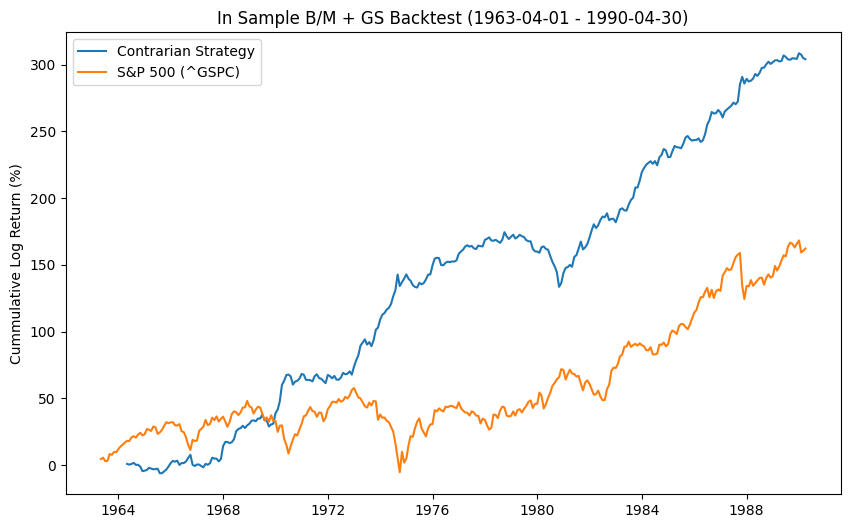

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(backtest['caldt'], backtest['cum_ret'] * 100, label='Contrarian Strategy')
plt.plot(bmk['caldt'], bmk['cum_ret'] * 100, label='S&P 500 (^GSPC)')
plt.title(f"In Sample B/M + GS Backtest ({start} - {end})")
plt.ylabel("Cummulative Log Return (%)")
plt.legend()
plt.show()

In [32]:
# Calculate napkin sharpe ratio using monthly returns

numerator = backtest['log_ret'].mean()
denominator = backtest['log_ret'].std()
scale = 12 / np.sqrt(12)

sharpe = numerator / denominator * scale

print(f"Sharpe Ratio: {round(sharpe,2)}")

Sharpe Ratio: 1.07


### 5 Factor Model Decomposition

In [33]:
# Pull in fama french 5 factors
fac = pd.read_csv("~/Data/fama_5_factors.csv")

# Create mdt variable for merging
fac['mdt'] = pd.to_datetime(fac['DATE'].astype(str), format='%Y%m').dt.strftime("%Y-%m")

fac

,DATE,Mkt-RF,SMB,HML,RMW,CMA,RF,mdt
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1963-07
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25,1963-08
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27,1963-09
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29,1963-10
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27,1963-11
...,...,...,...,...,...,...,...,...
729,202404,-4.67,-2.56,-0.52,1.48,-0.30,0.47,2024-04
730,202405,4.34,0.76,-1.66,2.98,-3.07,0.44,2024-05
731,202406,2.77,-4.37,-3.31,0.51,-1.78,0.41,2024-06
732,202407,1.24,8.28,5.73,0.22,0.43,0.45,2024-07


In [34]:
# Merge port and fac 
merge = pd.merge(backtest, fac, on='mdt', how='inner')

# Drop unecessary columns
merge = merge.drop(columns=['cum_ret', 'caldt', 'DATE'])

merge['log_ret'] = merge['log_ret'] * 100

merge['xs_log_ret'] = merge['log_ret'] - merge['RF']

merge = merge.rename(columns={'Mkt-RF': 'XS_MKT'})

merge

,mdt,log_ret,XS_MKT,SMB,HML,RMW,CMA,RF,xs_log_ret
0,1964-05,0.924371,1.42,-0.63,1.86,-0.16,0.17,0.26,0.664371
1,1964-06,-0.538596,1.27,0.29,0.62,-0.28,-0.17,0.30,-0.838596
2,1964-07,0.488454,1.74,0.50,0.75,0.08,1.91,0.30,0.188454
3,1964-08,0.828338,-1.44,0.41,0.08,0.12,0.35,0.28,0.548338
4,1964-09,-1.513651,2.69,-0.34,1.70,-0.56,0.62,0.28,-1.793651
...,...,...,...,...,...,...,...,...,...
307,1989-12,-0.355328,1.16,-2.27,0.16,-0.07,1.42,0.61,-0.965328
308,1990-01,4.229695,-7.85,-1.31,0.85,-1.17,1.35,0.57,3.659695
309,1990-02,-1.005685,1.11,1.17,0.64,-0.03,-0.66,0.57,-1.575685
310,1990-03,-2.643656,1.83,1.62,-2.92,2.04,-1.02,0.64,-3.283656


In [35]:
# Run a single factor model regression
model = smf.ols("xs_log_ret ~ XS_MKT", data=merge).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             xs_log_ret   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     161.7
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           4.21e-30
Time:                        08:27:00   Log-Likelihood:                -733.27
No. Observations:                 312   AIC:                             1471.
Df Residuals:                     310   BIC:                             1478.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5462      0.145      3.780      0.000       0.262       0.831
XS_MKT        -0.3980      0.031    -12.717      0.000      -0.460      -0.336
==============================================================================
Omnibus:                       13.321   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.211
Skew:                           0.220   Prob(JB):                     5.53e-06
Kurtosis:                       4.292   Cond. No.                         4.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Run a 5 factor model regression
model = smf.ols("xs_log_ret ~ XS_MKT + SMB + HML + RMW + CMA", data=merge).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             xs_log_ret   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     248.0
Date:                Tue, 08 Oct 2024   Prob (F-statistic):          2.36e-105
Time:                        08:27:00   Log-Likelihood:                -546.05
No. Observations:                 312   AIC:                             1104.
Df Residuals:                     306   BIC:                             1127.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0566      0.088      0.646      0.518      -0.116       0.229
XS_MKT        -0.1981      0.020     -9.723      0.000      -0.238      -0.158
SMB           -0.0128      0.030     -0.432      0.666      -0.071       0.045
HML            0.6456      0.049     13.303      0.000       0.550       0.741
RMW           -0.0163      0.067     -0.242      0.809      -0.149       0.116
CMA            0.3927      0.069      5.658      0.000       0.256       0.529
==============================================================================
Omnibus:                        4.252   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                5.324
Skew:                           0.050   Prob(JB):                       0.0698
Kurtosis:                       3.632   Cond. No.                         6.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# True sharpe ratio (includes the risk free rate)

numerator = (merge['log_ret'] - merge['RF']).mean()
denominator = merge['log_ret'].std()
scale = 12 / np.sqrt(12)

sharpe = numerator / denominator * scale

print(f"Sharpe Ratio: {round(sharpe,2)}")

Sharpe Ratio: 0.45


In [38]:
# Market sharpe over the same period

numerator = fac['Mkt-RF'].mean()
denominator = (fac['Mkt-RF'] + fac['RF']).std()
scale = 12 / np.sqrt(12)

sharpe = numerator / denominator * scale

print(f"Market Sharpe Ratio: {round(sharpe, 2)}")

Market Sharpe Ratio: 0.45
